<a href="https://colab.research.google.com/github/cmason30/datascience-funhouse/blob/master/pytorch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [26]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [27]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 2,  0,  7,  1,  3, 10,  5,  9,  4]), tensor([6, 8]))

In [28]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [29]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[1.5404],
        [1.7804]], grad_fn=<AddmmBackward>)

In [30]:
linear_model.weight

Parameter containing:
tensor([[0.1655]], requires_grad=True)

In [31]:
linear_model.bias

Parameter containing:
tensor([0.9795], requires_grad=True)

In [32]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.1450],
        [1.1450],
        [1.1450],
        [1.1450],
        [1.1450],
        [1.1450],
        [1.1450],
        [1.1450],
        [1.1450],
        [1.1450]], grad_fn=<AddmmBackward>)

In [33]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [34]:
linear_model.parameters()

<generator object Module.parameters at 0x7f8cf1e72938>

In [35]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.1033]], requires_grad=True), Parameter containing:
 tensor([-0.7541], requires_grad=True)]

In [36]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
  for epoch in range(1, n_epochs +1):
    t_p_train = model(t_u_train)
    loss_train = loss_fn(t_p_train, t_c_train)

    t_p_val = model(t_u_val)
    loss_val = loss_fn(t_p_val, t_c_val)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0:
      print(f"Epoch {epoch}, Training loss {loss_train.item(): .4f},"
            f" Validation loss {loss_val.item():.4f}")

In [37]:
training_loop(
  n_epochs = 3000,
  optimizer = optimizer, 
  model = linear_model, 
  loss_fn = nn.MSELoss(), 
  t_u_train = t_un_train, 
  t_u_val = t_un_val, 
  t_c_train = t_c_train, 
  t_c_val = t_c_val)

print(linear_model.weight) 
print(linear_model.bias)


Epoch 1, Training loss  225.6227, Validation loss 25.3520
Epoch 1000, Training loss  3.2090, Validation loss 5.7293
Epoch 2000, Training loss  2.2867, Validation loss 5.8853
Epoch 3000, Training loss  2.2529, Validation loss 6.0950
Parameter containing:
tensor([[5.4583]], requires_grad=True)
Parameter containing:
tensor([-17.7223], requires_grad=True)


In [38]:
seq_model = nn.Sequential(
            nn.Linear(1,13),
            nn.Tanh(),
            nn.Linear(13,1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [39]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [40]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [41]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
  ('hidden_linear', nn.Linear(1,8)),
  ('hidden_activation', nn.Tanh()),
  ('output_linear', nn.Linear(8,1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [42]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [43]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.3113], requires_grad=True)

In [44]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val=t_c_val
)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss  209.0987, Validation loss 17.4898
Epoch 1000, Training loss  4.6573, Validation loss 7.1953
Epoch 2000, Training loss  4.8927, Validation loss 8.0011
Epoch 3000, Training loss  2.4965, Validation loss 5.7048
Epoch 4000, Training loss  1.6325, Validation loss 4.9918
Epoch 5000, Training loss  1.4153, Validation loss 4.8743
output tensor([[0.2240],
        [7.4147]], grad_fn=<AddmmBackward>)
answer tensor([[3.],
        [6.]])
hidden tensor([[ 0.0341],
        [-0.8534],
        [-0.1968],
        [ 1.4072],
        [-0.0465],
        [ 1.3707],
        [-0.5591],
        [-1.3693]])


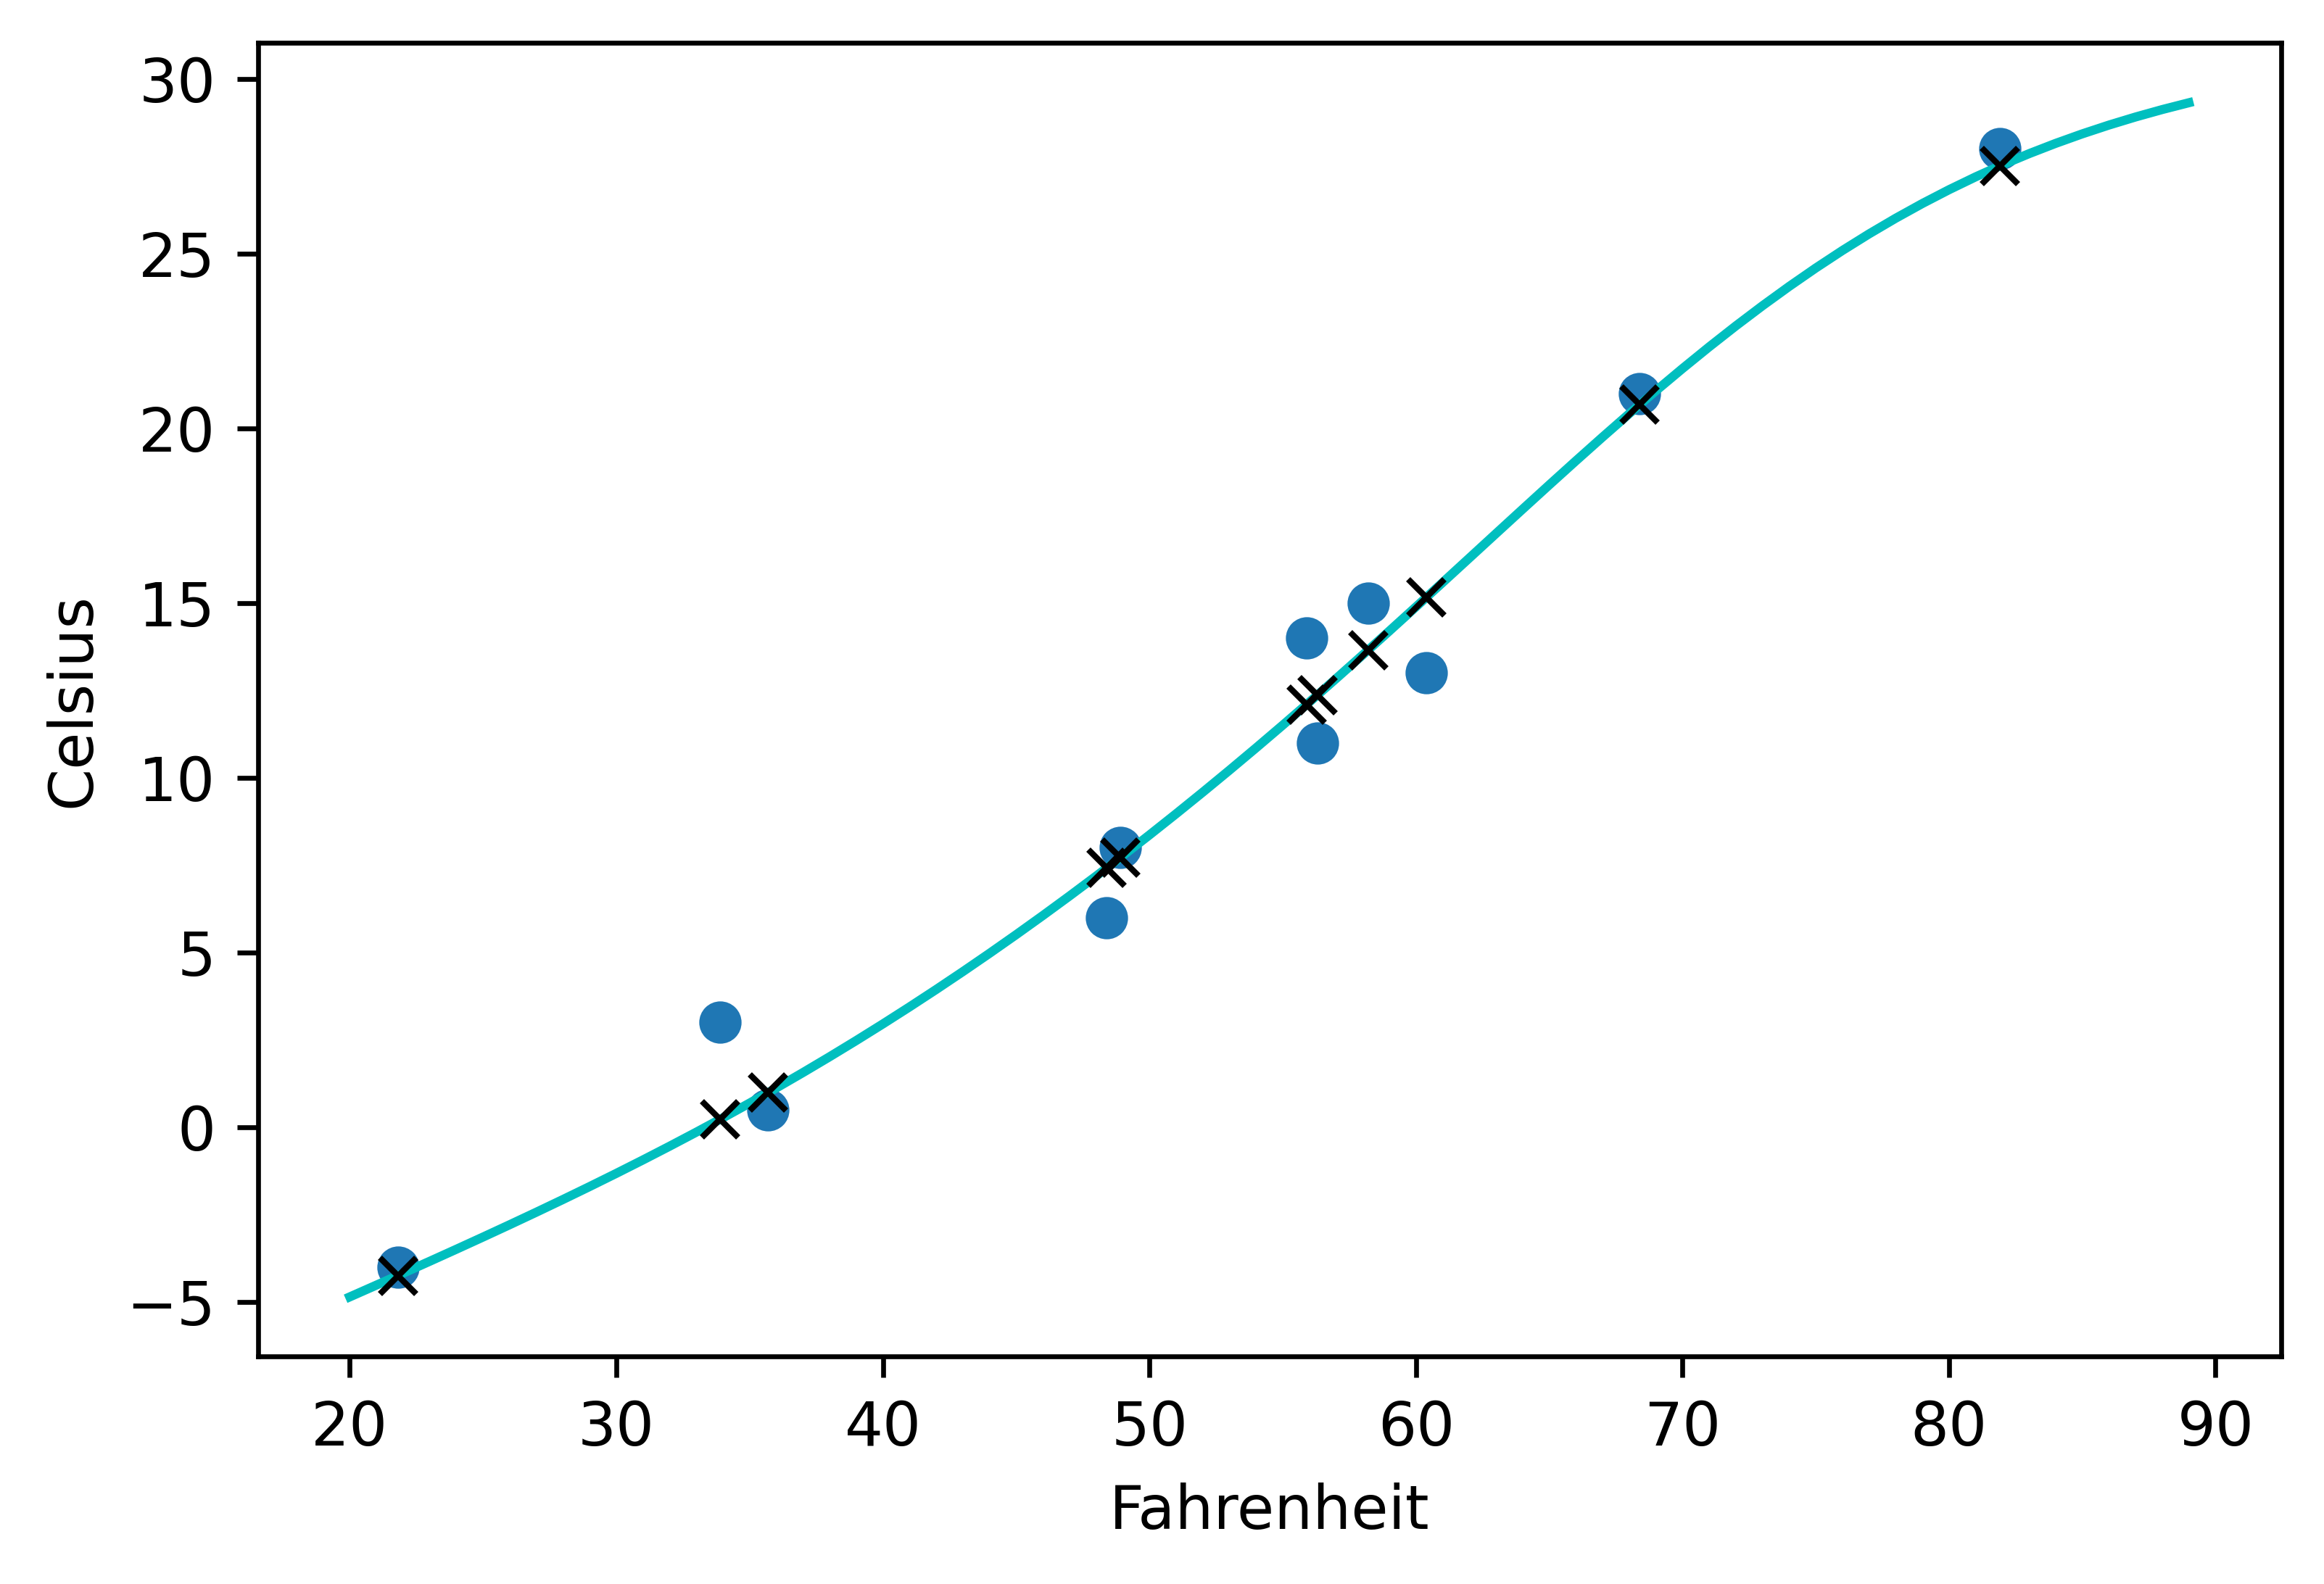

In [47]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1) 
fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-') 
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


